## Requirements

### Web-Scraping
#### 1. Take the base wg-gesucht URL and scrape the shared flats listed on the website
#### 2. most important data points are price, room size and number of flat mates

### Data Analyis
#### 1. Correlation analysis of room price and room size. Hypothesis: positive correlation
#### 2. Correlation analysis of room price and number of flat mates. Hypothesis: negative correlation

### Import all neccessary libraries

In [5]:
import requests
import random
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import scipy
from matplotlib import pyplot as plt


In [17]:
rentPrice = []
roomSize = []
print(rentPrice, roomSize)


[] []


In [23]:
proxies = [
    'http://24.106.221.230:53281',
    'http://118.70.12.171:53281',
    'http://198.199.86.11:8080',
    'http://107.173.80.140:9000',
    'http://159.203.61.169:8080',
    'http://134.209.29.120:3128',
    'http://192.140.42.83:31511',
    'http://20.187.77.5:80',
    'http://64.225.8.191:9986',
    'http://198.59.191.234:8080',
    'http://51.178.47.12:80',
    'http://82.180.163.163:80',
    'http://158.69.72.138:9300',
    'http://198.49.68.80:80',
    'http://51.15.192.229:8080',
    'http://161.35.70.249:8080',
    'http://143.110.232.177:80',
    'http://154.118.228.212:80',
    'http://177.87.144.122:5566',
    'http://200.25.254.193:54240'
    ]

headers = { 
    "User-Agent": "Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:109.0) Gecko/20100101 Firefox/111.0"
}

def makeRequest(url):
    try:
        proxy = {'http' : proxies[random.randint(0, len(proxies) - 1)]}
        print('Current Proxy: ', proxy)
        return requests.get(url, proxies={'http' : '82.180.163.163:80'}, headers=headers, timeout=5)
    except:
        print("PROBLEM WHILE MAKING REQUEST")

In [27]:
#df.head()
for i in range(10):
    print(i)
    res = makeRequest(f'https://www.wg-gesucht.de/wg-zimmer-in-Mannheim.85.0.0.{i}.html')
    try: 
        df = pd.read_html(res.text)[0]
    except:
        print("Error")
        break
        
    df1 = df.iloc[:,3].tolist()
    df2 = df.iloc[:,4].tolist()
    df1 = df1[0: len(df1) -1 ]
    df2 = df2[0: len(df2) -1 ]

    for i, el  in enumerate(df1):
        df1[i] = int(el[0 : len(el) - 1])

    for i, el in enumerate(df2):
        df2[i] = int(el[0 : len(el) - 2])

    rentPrice = rentPrice + df1

    roomSize = roomSize + df2



0
Current Proxy:  {'http': 'http://198.59.191.234:8080'}
1
Current Proxy:  {'http': 'http://64.225.8.191:9986'}
2
Current Proxy:  {'http': 'http://20.187.77.5:80'}
3
Current Proxy:  {'http': 'http://158.69.72.138:9300'}
4
Current Proxy:  {'http': 'http://200.25.254.193:54240'}
5
Current Proxy:  {'http': 'http://177.87.144.122:5566'}
6
Current Proxy:  {'http': 'http://134.209.29.120:3128'}
7
Current Proxy:  {'http': 'http://64.225.8.191:9986'}
8
Current Proxy:  {'http': 'http://158.69.72.138:9300'}
9
Current Proxy:  {'http': 'http://154.118.228.212:80'}


In [28]:
print(len(rentPrice), rentPrice)
print(len(roomSize), roomSize)
data = pd.DataFrame(list(zip(rentPrice, roomSize)), columns=['Rent Price', 'Room Size'])
data.to_excel('shared_flat_data.xlsx')

400 [480, 460, 450, 376, 460, 431, 395, 300, 450, 320, 450, 300, 560, 460, 400, 250, 510, 600, 320, 320, 429, 530, 430, 550, 250, 440, 340, 320, 380, 465, 290, 470, 450, 480, 350, 370, 500, 320, 190, 525, 450, 610, 565, 390, 650, 450, 500, 500, 385, 400, 450, 661, 390, 490, 480, 415, 530, 450, 375, 480, 386, 565, 345, 500, 590, 600, 460, 550, 520, 600, 600, 351, 465, 350, 575, 535, 400, 470, 540, 600, 300, 495, 500, 425, 495, 487, 455, 500, 440, 395, 600, 595, 429, 400, 485, 545, 355, 400, 500, 300, 480, 460, 450, 376, 460, 431, 395, 300, 450, 320, 450, 300, 560, 460, 400, 250, 510, 600, 320, 320, 429, 530, 430, 550, 250, 440, 340, 320, 380, 465, 290, 470, 450, 480, 350, 370, 500, 320, 190, 525, 450, 610, 565, 390, 650, 450, 500, 500, 385, 400, 450, 661, 390, 490, 480, 415, 530, 450, 375, 480, 386, 565, 345, 500, 590, 600, 460, 550, 520, 600, 600, 351, 465, 350, 575, 535, 400, 470, 540, 600, 300, 495, 500, 425, 495, 487, 455, 500, 440, 395, 600, 595, 429, 400, 485, 545, 355, 400, 500, 

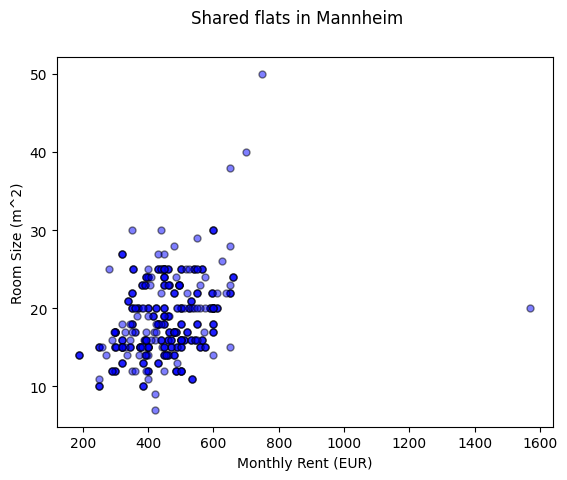

PearsonRResult(statistic=0.3187299529509427, pvalue=6.77231350348171e-11)

In [29]:
plt.style.use('default')
fig, ax = plt.subplots()
fig.suptitle("Shared flats in Mannheim")
#ax.grid()
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Monthly Rent (EUR)')
plt.ylabel('Room Size (m^2)')
plt.scatter(rentPrice, roomSize, s=25, c='blue',edgecolors='black', linewidths=1, alpha=0.5)
plt.show()

scipy.stats.pearsonr(rentPrice, roomSize)
